In [6]:
""" Custom batch class for storing mnist batch and models

"""
import sys

import numpy as np
import os
import blosc

import tensorflow as tf
import matplotlib.pyplot as plt

import os
import blosc

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
sys.path.append("..")


from dataset import DatasetIndex, Dataset

from dataset import Batch, action, model, inbatch_parallel
from dataset.dataset.image import ImagesBatch

In [7]:
class MnistBatch(ImagesBatch):
    """ Mnist batch and models
    """
    def __init__(self, index, *args, **kwargs):
        """ Init func, inherited from base batch
        """
        super().__init__(index, *args, **kwargs)
        self.images = None
        self.labels = None



    def post_function(self, list_results):
        '''Post function for parallel shift, gathers results of every worker'''
        result_batch = np.array(list_results)
        self.images = result_batch
        return self

    def init_function(self):
        '''Init function for parallel shift
        returns list of indices, each of them will be sent to the worker separately
        '''
        return range(self.images.shape[0])

    @action
    @inbatch_parallel(init='init_function', post='post_function', target='threads')
    def shift_flattened_pic(self, idx, max_margin=8):
        """ Apply random shift to a flattened pic
        
        Args:
            pic: ndarray of shape=(784) representing a pic to be flattened
        Return:
            flattened shifted pic
        """
        
        pic = self.images[idx]
        padded = np.pad(pic, pad_width=[[max_margin, max_margin], [max_margin, max_margin]], 
                        mode='minimum')
        left_lower = np.random.randint(2 * max_margin, size=2)
        slicing = (slice(left_lower[0], left_lower[0] + 28),
                   slice(left_lower[1], left_lower[1] + 28))
        res = padded[slicing]
        return res

    
    @property
    def components(self):
        """ Components of mnist-batch
        """
        return 'images', 'labels'

    @action
    def load(self, src, fmt='blosc'):
        """ Load mnist pics with specifed indices

        Args:
            fmt: format of source. Can be either 'blosc' or 'ndarray'
            src: if fmt='blosc', then src is a path to dir with blosc-packed
                mnist images and labels are stored.
                if fmt='ndarray' - this is a tuple with arrays of images and labels

        Return:
            self
        """
        if fmt == 'blosc':     
            # read blosc images, labels
            with open('mnist_pics.blk', 'rb') as file:
                self.images = blosc.unpack_array(file.read())[self.indices]
                self.images = np.reshape(self.images, (65000, 28, 28))

            with open('mnist_labels.blk', 'rb') as file:
                self.labels = blosc.unpack_array(file.read())[self.indices]
        elif fmt == 'ndarray':
            all_images, all_labels = src
            self.images = all_images[self.indices]
            self.labels = all_labels[self.indices]

        return self

    @model()
    def convy():
        """ Conv-net mnist classifier

        Args:
            ___
        Return:
            [[placeholder for input, ph for true labels, loss, train_step],
             [true categorical labels, categorical_hat labels, accuracy]]
        """
        # build the net
        training = tf.placeholder(tf.bool, shape=[], name='mode')
        x = tf.placeholder(tf.float32, [None, 28, 28], name='x')
        x_as_pics = tf.reshape(x, shape=[-1, 28, 28, 1])
        
        
        net = tf.layers.conv2d(x_as_pics, filters=4, kernel_size=(7,7), strides=(1, 1), padding='same')
        net = tf.layers.max_pooling2d(net, pool_size=(6, 6), strides=(2, 2), padding='same')
        net = tf.layers.batch_normalization(net, training=training)
        net = tf.nn.relu(net)
        
        net = tf.layers.conv2d(net, filters=16, kernel_size=(5, 5), strides=(1, 1), padding='same')
        net = tf.layers.max_pooling2d(net, pool_size=(5, 5), strides=(2, 2), padding='same')
        net = tf.layers.batch_normalization(net, training=training)
        net = tf.nn.relu(net)


        net = tf.layers.conv2d(net, filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same')
        net = tf.layers.max_pooling2d(net, pool_size=(2, 2), strides=(2, 2), padding='same')
        net = tf.layers.batch_normalization(net, training=training)
        net = tf.nn.relu(net)

        
        net = tf.contrib.layers.flatten(net)

        # dropout 
        keep_prob = tf.placeholder(tf.float32)
        # net = tf.nn.dropout(net, keep_prob)


        net = tf.layers.dense(net, 128, kernel_initializer=tf.truncated_normal_initializer(0.0, 1))
#         net = tf.layers.dense(net, 128, kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))

        net = tf.nn.relu(net)
        
        net = tf.layers.dense(net, 10, kernel_initializer=tf.truncated_normal_initializer(0.0, 1))
#         net = tf.layers.dense(net, 10, kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))

        probs = tf.nn.softmax(logits=net, name='softmax_output')
    
        # placeholder for correct labels
        y_ = tf.placeholder(tf.float32, [None, 10], name='y_')

        # loss
#         loss = tf.nn.softmax_cross_entropy_with_logits(logits=net, labels=y_, name='loss')
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=net, labels=y_, name='loss'))
    
        global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 0.0001
        
        learning_rate = tf.placeholder(tf.float32, shape=[], name='lr')
        # learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
        #                                           100, 0.85, staircase=True)

        # optimization step
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_step = (
                tf.train.GradientDescentOptimizer(learning_rate)
                .minimize(loss, global_step=global_step)
                )

        # stats
        labels_hat = tf.cast(tf.argmax(net, axis=1), tf.float32, name='labels_hat')
        labels = tf.cast(tf.argmax(y_, axis=1), tf.float32, name='labels')
        accuracy = tf.reduce_mean(tf.cast(tf.equal(labels_hat, labels), tf.float32), name='accuracy')
        
        softmax = tf.placeholder(tf.float32, [None, 10], name='softmax')
        
        predicts = tf.placeholder(tf.float32, [None, 10], name='predicts')
        test_acc = tf.reduce_mean(tf.cast(tf.equal(predicts, labels), tf.float32), name='accuracy')
        
        print_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=softmax, labels=y_, name='print_loss'))
        
        return [[x, y_, loss, train_step, training, keep_prob], [labels, labels_hat, accuracy], [probs], [learning_rate, global_step, print_loss], [softmax, predicts, test_acc]]

    @action(model='convy')
    def predict(self, model, sess, pics, y_true, y_predict, probabilities):
        ''' Predict labels '''
        x, y_, _, _, training, keep_prob = model[0]
        labels, labels_hat, _ = model[1]
        probs = model[2][0]
        probabilities.append(sess.run(probs, feed_dict={x:self.images, training: False, keep_prob: 1.0}))
        y_predict.append(sess.run(labels_hat, feed_dict={x:self.images, training: False, keep_prob: 1.0}))
        y_true.append(sess.run(labels, feed_dict={y_:self.labels}))
        pics.append(self.images)
        return self

    @action(model='convy')
    def train_convy(self, model, sess, alpha, period, n_iterations, accs, loss_history):
        """ Train-action for convy-model

        Args:
            model: do not supply this arg, always the output of convy-model defined above
            sess: tf-session in which learning variables are to be updated
        """        
        
        x, y_, loss, train_step, training, keep_prob = model[0]
        learning_rate, global_step, _ = model[3]
        
        _, _, accuracy = model[1]

        alpha = tf.cast(alpha, tf.float32)
        
        global_step = sess.run(global_step)
    
        period = tf.cast(period, tf.float32)
        n_iterations = tf.cast(n_iterations, tf.float32)
        n_cycles = n_iterations // period
        
        
        cyclic_learning_rate = alpha / tf.cast(2.0, tf.float32) * (tf.cos(tf.cast(np.pi, tf.float32) * ((tf.cast(global_step, tf.float32) - 1) % (period)) / (period)) + 1)          
        cyclic_learning_rate = sess.run(cyclic_learning_rate)
        # print ('HHHHHHHHEEEEEEEEEEEY', cyclic_learning_rate)
        sess.run(train_step, feed_dict={x: self.images, y_: self.labels, training: True, keep_prob: 0.7, learning_rate:cyclic_learning_rate})        
        
        period = sess.run(period)
        
        if (global_step) % period == 0:
            if global_step == 0:
                pass
            else:
                print ('hey')
                saver = tf.train.Saver()
                saver.save(sess, 'trained/model', global_step=global_step)
        
#         if global_step == (n_iterations - 1):
#             print ('hey')
#             saver = tf.train.Saver()
#             saver.save(sess, 'trained/model', global_step=global_step)

        
        loss_history.append(sess.run(loss, feed_dict={x: self.images, y_: self.labels, training: False, keep_prob: 1.0}))

        accs.append(sess.run(accuracy, feed_dict={x: self.images, y_: self.labels, training: False, keep_prob: 1.0}))

        return self


    @action(model='convy')
    def update_stats(self, model, sess, period, n_iterations, accs, loss_history):
        """ Append accuracy that is obtained by convy-model given weights stored in sess Tf-session

        Args:
            model: do not supply this arg, always the output of convy-model defined above
            sess: tf-session with trained (to some extent) weights
            accs: list with accuracies
        """
        
        n_cycles = n_iterations // period
        results = []
        for i in range(1, n_cycles + 1):
            address = 'trained/model' + '-' + str(i*period) + '.meta'

            grapphy_2 = tf.Graph()
            with grapphy_2.as_default():
                new_sess = tf.Session()

                new_saver = tf.train.import_meta_graph(address)
                new_saver.restore(new_sess, tf.train.latest_checkpoint('trained/'))
                training = grapphy_2.get_tensor_by_name('mode:0')
                x = grapphy_2.get_tensor_by_name('x:0')
                softmax_output = grapphy_2.get_tensor_by_name('softmax_output:0')

                res = new_sess.run(softmax_output, feed_dict={x:imgs, training:False})
                results.append(res)
            
        avg_softmax = np.average(results, axis=0)
        my_predicts = np.argmax(a, axis=1)
        
        
        labels = np.argmax(self.labels, axis=1)
        
        
        _, _, accuracy = model[1]
        x, y_, _, _, training, keep_prob = model[0]
        _, _, print_loss = model[3]
        softmax, predicts, test_acc = model[4]
        
        loss_history.append(sess.run(print_loss, feed_dict={softmax: avg_softmax, y_: self.labels, training: False, keep_prob: 1.0}))

        accs.append(sess.run(accuracy, feed_dict={predicts: my_predicts, y_: self.labels, training: False, keep_prob: 1.0}))
        return self

    
#     @action(model='convy')
#     def update_stats(self, model, sess, accs, loss_history):
#         """ Append accuracy that is obtained by convy-model given weights stored in sess Tf-session

#         Args:
#             model: do not supply this arg, always the output of convy-model defined above
#             sess: tf-session with trained (to some extent) weights
#             accs: list with accuracies
#         """
        
        
#         _, _, accuracy = model[1]
#         x, y_, _, _, training, keep_prob = model[0]
#         _, _, print_loss = model[3]
#         loss_history.append(sess.run(print_loss, feed_dict={x: self.images, y_: self.labels, training: False, keep_prob: 1.0}))

#         accs.append(sess.run(accuracy, feed_dict={x: self.images, y_: self.labels, training: False, keep_prob: 1.0}))
#         return self


def draw_stats(stats, title):
    plt.title(title)
    plt.plot(stats)
    plt.xlabel('iteration')
    plt.ylabel('accuracy')
    plt.show()

In [8]:
# """ Custom batch class for storing mnist batch and models
# """
# import sys

# import numpy as np
# import os
# import blosc

# import tensorflow as tf
# import matplotlib.pyplot as plt

# from dataset import Batch, action, model, inbatch_parallel, ImagesBatch


# class MnistBatch(ImagesBatch):
#     """ Mnist batch and models
#     """
#     def __init__(self, index, *args, **kwargs):
#         """ Init func, inherited from base batch
#         """
#         super().__init__(index, *args, **kwargs)
#         self.images = None
#         self.labels = None



#     def post_function(self, list_results):
#         '''Post function for parallel shift, gathers results of every worker'''
#         result_batch = np.array(list_results)
#         self.images = result_batch
#         return self

#     def init_function(self):
#         '''Init function for parallel shift
#         returns list of indices, each of them will be sent to the worker separately
#         '''
#         return range(self.images.shape[0])

#     @action
#     @inbatch_parallel(init='init_function', post='post_function', target='threads')
#     def shift_flattened_pic(self, idx, max_margin=8):
#         """ Apply random shift to a flattened pic
        
#         Args:
#             pic: ndarray of shape=(784) representing a pic to be flattened
#         Return:
#             flattened shifted pic
#         """
        
#         pic = self.images[idx]
#         padded = np.pad(pic, pad_width=[[max_margin, max_margin], [max_margin, max_margin]], 
#                         mode='minimum')
#         left_lower = np.random.randint(2 * max_margin, size=2)
#         slicing = (slice(left_lower[0], left_lower[0] + 28),
#                    slice(left_lower[1], left_lower[1] + 28))
#         res = padded[slicing]
#         return res

    
#     @property
#     def components(self):
#         """ Components of mnist-batch
#         """
#         return 'images', 'labels'

#     @action
#     def load(self, src, fmt='blosc'):
#         """ Load mnist pics with specifed indices

#         Args:
#             fmt: format of source. Can be either 'blosc' or 'ndarray'
#             src: if fmt='blosc', then src is a path to dir with blosc-packed
#                 mnist images and labels are stored.
#                 if fmt='ndarray' - this is a tuple with arrays of images and labels

#         Return:
#             self
#         """
#         if fmt == 'blosc':     
#             # read blosc images, labels
#             with open('mnist_pics.blk', 'rb') as file:
#                 self.images = blosc.unpack_array(file.read())[self.indices]
#                 self.images = np.reshape(self.images, (65000, 28, 28))

#             with open('mnist_labels.blk', 'rb') as file:
#                 self.labels = blosc.unpack_array(file.read())[self.indices]
#         elif fmt == 'ndarray':
#             all_images, all_labels = src
#             self.images = all_images[self.indices]
#             self.labels = all_labels[self.indices]

#         return self

#     @model()
#     def convy():
#         """ Conv-net mnist classifier

#         Args:
#             ___
#         Return:
#             [[placeholder for input, ph for true labels, loss, train_step],
#              [true categorical labels, categorical_hat labels, accuracy]]
#         """
#         # build the net
#         training = tf.placeholder(tf.bool, shape=[], name='mode')
#         x = tf.placeholder(tf.float32, [None, 28, 28])
#         x_as_pics = tf.reshape(x, shape=[-1, 28, 28, 1])
        
        
#         net = tf.layers.conv2d(x_as_pics, filters=4, kernel_size=(7,7), strides=(1, 1), padding='same')
#         net = tf.layers.max_pooling2d(net, pool_size=(6, 6), strides=(2, 2), padding='same')
#         net = tf.layers.batch_normalization(net, training=training)
#         net = tf.nn.relu(net)
        
#         net = tf.layers.conv2d(net, filters=16, kernel_size=(5, 5), strides=(1, 1), padding='same')
#         net = tf.layers.max_pooling2d(net, pool_size=(5, 5), strides=(2, 2), padding='same')
#         net = tf.layers.batch_normalization(net, training=training)
#         net = tf.nn.relu(net)


#         net = tf.layers.conv2d(net, filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same')
#         net = tf.layers.max_pooling2d(net, pool_size=(2, 2), strides=(2, 2), padding='same')
#         net = tf.layers.batch_normalization(net, training=training)
#         net = tf.nn.relu(net)

        
#         net = tf.contrib.layers.flatten(net)

#         # dropout 
#         keep_prob = tf.placeholder(tf.float32)
#         # net = tf.nn.dropout(net, keep_prob)


#         net = tf.layers.dense(net, 128, kernel_initializer=tf.truncated_normal_initializer(0.0, 1))

#         net = tf.nn.relu(net)
        
#         net = tf.layers.dense(net, 10, kernel_initializer=tf.truncated_normal_initializer(0.0, 1))


#         probs = tf.nn.softmax(logits=net)
#         # placeholder for correct labels
#         y_ = tf.placeholder(tf.float32, [None, 10])

#         # loss
#         loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=net, labels=y_, name='loss'))
# #         loss = tf.nn.softmax_cross_entropy_with_logits(logits=net, labels=y_, name='loss')
        
#         global_step = tf.Variable(0, trainable=False)
#         starter_learning_rate = 0.0001
#         learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
#                                                    100, 0.96, staircase=True)

#         # optimization step
#         update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#         with tf.control_dependencies(update_ops):
#             train_step = (
#                 tf.train.GradientDescentOptimizer(learning_rate)
#                 .minimize(loss, global_step=global_step)
#                 )

#         # stats
#         labels_hat = tf.cast(tf.argmax(net, axis=1), tf.float32, name='labels_hat')
#         labels = tf.cast(tf.argmax(y_, axis=1), tf.float32, name='labels')
#         accuracy = tf.reduce_mean(tf.cast(tf.equal(labels_hat, labels), tf.float32), name='accuracy')
        
#         print_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=net, labels=y_, name='print_loss'))

#         return [[x, y_, loss, train_step, training, keep_prob], [labels, labels_hat, accuracy], [probs], [learning_rate], [loss]]

#     @action(model='convy')
#     def predict(self, model, sess, pics, y_true, y_predict, probabilities):
#         ''' Predict labels '''
#         x, y_, _, _, training, keep_prob = model[0]
#         labels, labels_hat, _ = model[1]
#         probs = model[2][0]
#         probabilities.append(sess.run(probs, feed_dict={x:self.images, training: False, keep_prob: 1.0}))
#         y_predict.append(sess.run(labels_hat, feed_dict={x:self.images, training: False, keep_prob: 1.0}))
#         y_true.append(sess.run(labels, feed_dict={y_:self.labels}))
#         pics.append(self.images)
#         return self

#     @action(model='convy')
#     def train_convy(self, model, sess):
#         """ Train-action for convy-model

#         Args:
#             model: do not supply this arg, always the output of convy-model defined above
#             sess: tf-session in which learning variables are to be updated
#         """
        
#         x, y_, _, train_step, training, keep_prob = model[0]
#         sess.run(train_step, feed_dict={x: self.images, y_: self.labels, training: True, keep_prob: 0.7})        
#         return self

#     @action(model='convy')
#     def update_stats(self, model, sess, accs, loss_history):
#         """ Append accuracy that is obtained by convy-model given weights stored in sess Tf-session

#         Args:
#             model: do not supply this arg, always the output of convy-model defined above
#             sess: tf-session with trained (to some extent) weights
#             accs: list with accuracies
#         """
#         _, _, accuracy = model[1]
#         x, y_, _, _, training, keep_prob = model[0]
#         learning_rate = model[3]
#         print_loss = model[4]
#         loss_history.append(sess.run(print_loss, feed_dict={x: self.images, y_: self.labels, training: False, keep_prob: 1.0}))

#         accs.append(sess.run(accuracy, feed_dict={x: self.images, y_: self.labels, training: False, keep_prob: 1.0}))
#         return self

# def draw_stats(stats, title):
#     plt.title(title)
#     plt.plot(stats)
#     plt.xlabel('iteration')
#     plt.ylabel('accuracy')
#     plt.show()

In [9]:
%matplotlib inline
%env CUDA_VISIBLE_DEVICES = 1

src = 'C:/Users/Dari/Documents/az_training/task_03'

with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    full_imgs = blosc.unpack_array(file.read())
    
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    full_labs = blosc.unpack_array(file.read())
    
src = (np.reshape(full_imgs, (65000, 28, 28)), full_labs)
# src = (full_imgs, full_labs)

env: CUDA_VISIBLE_DEVICES=1


In [10]:
LEN_MNIST = 65000
indy = DatasetIndex(np.arange(LEN_MNIST))

mnistset = Dataset(indy, batch_class=MnistBatch)
mnistset.cv_split([0.9, 0.1])

bch = MnistBatch(indy.create_subset(indy.indices[1:5]))

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
stats = []
loss_history = []

In [12]:
alpha = 0.001
period = 200
n_iterations = 401

In [32]:
!nvidia-smi

Thu Aug 17 23:28:25 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.94                 Driver Version: 384.94                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1050   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   40C    P8    N/A /  N/A |   3219MiB /  4096MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
900 // 300

3

In [7]:
# pipeline for train
ppl = (mnistset.train.pipeline().
       load(src=src, fmt='ndarray').
       train_convy(sess))

# pipeline for test
ppl_test = (mnistset.test.pipeline().
            load(src=src, fmt='ndarray').
            update_stats(sess, stats, loss_history))

In [8]:
for i in tqdm(range(n_iterations)):
    ppl.next_batch(100, n_epochs=None)
    ppl_test.next_batch(100, n_epochs=None)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 54.57it/s]


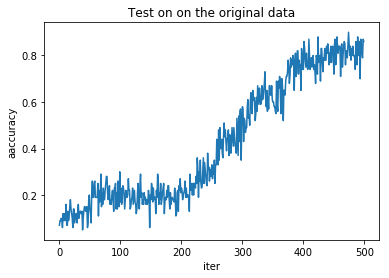

In [9]:
plt.title('Test on on the original data')
plt.plot(stats)
plt.xlabel('iter')
plt.ylabel('aaccuracy')
plt.show()

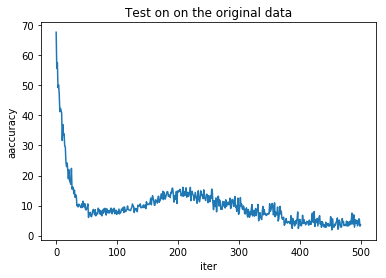

In [10]:
plt.title('Test on on the original data')
plt.plot(loss_history)
plt.xlabel('iter')
plt.ylabel('aaccuracy')
plt.show()

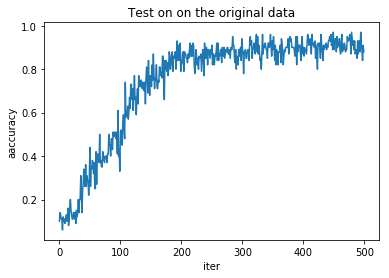

In [9]:
plt.title('Test on on the original data')
plt.plot(stats)
plt.xlabel('iter')
plt.ylabel('aaccuracy')
plt.show()

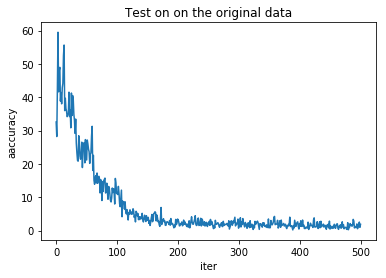

In [10]:
plt.title('Test on on the original data')
plt.plot(loss_history)
plt.xlabel('iter')
plt.ylabel('aaccuracy')
plt.show()

In [13]:
train_loss_history = [] 
train_stats = []

In [14]:
# !nvidia-smi

In [15]:
# pipeline for train
ppl = (mnistset.train.pipeline().
       load(src=src, fmt='ndarray').
       train_convy(sess,  alpha, period, n_iterations, train_stats, train_loss_history))

# pipeline for test
ppl_test = (mnistset.test.pipeline().
            load(src=src, fmt='ndarray').
            update_stats(sess, period, n_iterations, stats, loss_history))

In [16]:
for i in tqdm(range(n_iterations)):
    ppl.next_batch(100, n_epochs=None)
    # ppl_tebst.next_batch(100, n_epochs=None)

 13%|██████████▋                                                                      | 53/401 [00:09<01:04,  5.42it/s]


KeyboardInterrupt: 

In [11]:
for i in tqdm(range(n_iterations)):
    ppl.next_batch(100, n_epochs=None)
    # ppl_tebst.next_batch(100, n_epochs=None)

 50%|███████████████████████████████████████▋                                        | 199/401 [01:22<01:35,  2.11it/s]

hey


100%|███████████████████████████████████████████████████████████████████████████████▌| 399/401 [03:13<00:01,  1.76it/s]

hey


100%|████████████████████████████████████████████████████████████████████████████████| 401/401 [03:22<00:00,  2.25s/it]


[]

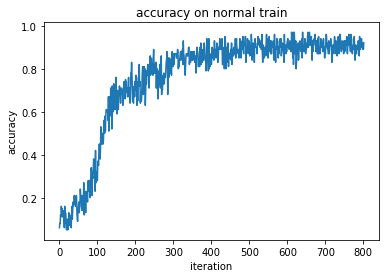

In [12]:
draw_stats(train_stats, 'accuracy on normal train')

In [27]:
np.average(train_stats[400:])

0.8999005

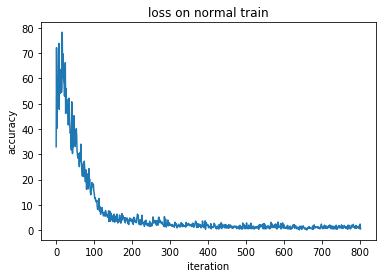

In [13]:
draw_stats(train_loss_history, 'loss on normal train')

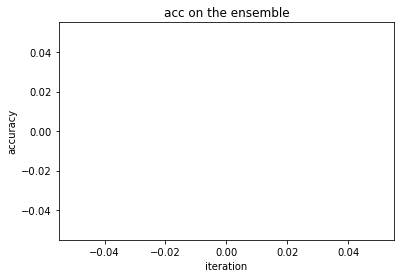

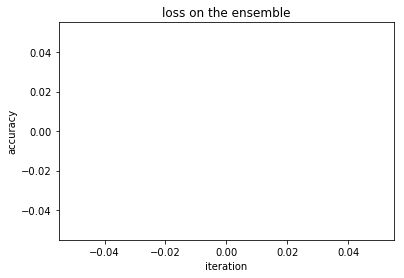

In [14]:
draw_stats(stats,  'acc on the ensemble')
draw_stats(loss_history,  'loss on the ensemble')

In [ ]:
st_1 = []
l_1 = []
ppl_test_train_data = (mnistset.train.pipeline().
            load(src=src, fmt='ndarray').
            update_stats(sess, period, n_iterations, st_1, l_1))

In [19]:
test_batch = mnistset.test.p.load(src=src, fmt='ndarray').run(len(mnistset.test.indices))
src = (np.reshape(full_imgs, (65000, 28, 28)), full_labs)

In [20]:
imgs, lbls = src
imgs = imgs[:100, :, :]
lbls = lbls[:100, :]

In [22]:
n_cycles = 2
period = 200
# for i in tqdm(range(n_iterations)):
#     # ppl.next_batch(100, n_epochs=None)
#     #ppl_test.next_batch(100, n_epochs=None)

results = []
for i in range(1, n_cycles + 1):
#         with tf.variable_scope(str(n_cycles)):
    address = 'trained/model' + '-' + str(i*period) + '.meta'
#                 new_saver = tf.train.import_meta_graph(address)
#                 new_saver.restore(new_sess, tf.train.latest_checkpoint('trained/'))

    #address = 'trained/model-200.meta'
    grapphy_2 = tf.Graph()
    with grapphy_2.as_default():
#                 new_sess = tf.Session(graph=grapphy_2)
        new_sess = tf.Session()

        new_saver = tf.train.import_meta_graph(address)
        new_saver.restore(new_sess, tf.train.latest_checkpoint('trained/'))
        training = grapphy_2.get_tensor_by_name('mode:0')
        x = grapphy_2.get_tensor_by_name('x:0')
        softmax_output = grapphy_2.get_tensor_by_name('softmax_output:0')
        # new_sess.run(tf.global_variables_initializer())

        res = new_sess.run(softmax_output, feed_dict={x:imgs, training:False})
        results.append(res)
        print (res.shape)
print ('done')

INFO:tensorflow:Restoring parameters from trained/model-800
(100, 10)
INFO:tensorflow:Restoring parameters from trained/model-800
(100, 10)
done


In [23]:
results = np.array(results)

In [50]:
results.shape

(2, 100, 10)

In [24]:
a = np.average(results, axis=0)
b = np.argmax(a, axis=1)
b

array([2, 1, 4, 9, 1, 3, 6, 0, 8, 8, 6, 1, 6, 4, 6, 5, 2, 6, 2, 9, 3, 0, 5,
       6, 0, 7, 3, 7, 0, 9, 4, 6, 6, 0, 6, 8, 1, 6, 9, 0, 7, 7, 5, 3, 7, 4,
       2, 9, 1, 0, 4, 3, 3, 8, 8, 7, 1, 9, 1, 2, 1, 9, 9, 8, 5, 0, 3, 2, 2,
       5, 7, 7, 3, 8, 8, 2, 1, 9, 0, 1, 1, 8, 7, 0, 8, 0, 4, 1, 2, 3, 3, 1,
       1, 6, 2, 1, 8, 4, 8, 6], dtype=int64)

In [25]:
c = np.argmax(lbls, axis=1)
c

array([2, 1, 4, 9, 1, 3, 6, 0, 8, 8, 6, 1, 2, 4, 6, 5, 2, 6, 2, 4, 3, 0, 5,
       6, 0, 7, 5, 7, 0, 9, 4, 6, 6, 0, 6, 8, 1, 6, 9, 0, 9, 7, 5, 3, 7, 4,
       0, 9, 1, 0, 4, 3, 3, 8, 8, 7, 1, 9, 1, 8, 1, 9, 9, 8, 0, 0, 3, 2, 1,
       5, 7, 3, 3, 8, 8, 2, 1, 9, 0, 1, 1, 8, 7, 0, 8, 0, 4, 1, 2, 3, 3, 1,
       1, 6, 2, 1, 8, 4, 8, 6], dtype=int64)

In [26]:
from sklearn.metrics import accuracy_score
accuracy_score(b, c)

0.91000000000000003

In [ ]:
#### plt.title('Test on on the original data')
plt.plot(train_stats)
#plt.axvline(x=201, c='r')

plt.xlabel('iter')
plt.ylabel('aaccuracy')
plt.show()

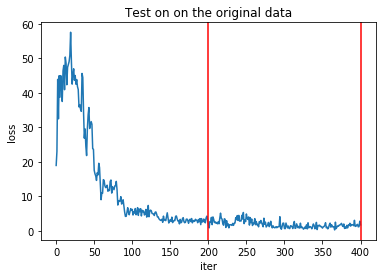

In [14]:
plt.title('Test on on the original data')
plt.plot(train_loss_history)
plt.xlabel('iter')
plt.axvline(x=200, c='r')
plt.axvline(x=400, c='r')

plt.ylabel('loss')
plt.show()

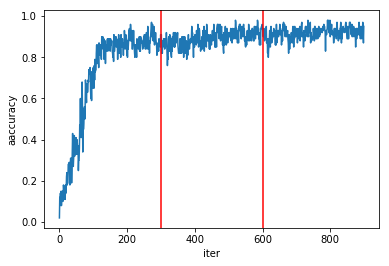

In [25]:
#### plt.title('Test on on the original data')
plt.plot(stats)
plt.xlabel('iter')
plt.ylabel('aaccuracy')
plt.axvline(x=301, c='r')
plt.axvline(x=601, c='r')

plt.show()

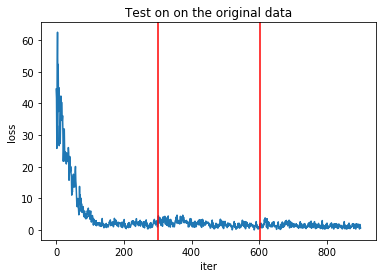

In [24]:
plt.title('Test on on the original data')
plt.plot(loss_history)
plt.xlabel('iter')
plt.ylabel('loss')
plt.axvline(x=301, c='r')
plt.axvline(x=601, c='r')

plt.show()

In [38]:
bch.images

In [15]:
new_sess = tf.Session()
address = 'trained/model-200.meta'
grapphy_2 = tf.Graph()
with grapphy_2.as_default():
    new_sess = tf.Session()

    new_saver = tf.train.import_meta_graph(address)
    new_saver.restore(new_sess, tf.train.latest_checkpoint('trained/'))
    
    x = grapphy_2.get_tensor_by_name('x:0')
    softmax_output = grapphy_2.get_tensor_by_name('softmax_output:0')
    new_sess.run(tf.local_variables_initializer())

    res = new_sess.run(softmax_output, feed_dict={x:bch.images})
    print (res)

INFO:tensorflow:Restoring parameters from trained/model-400


ValueError: Cannot feed value of shape () for Tensor 'x:0', which has shape '(?, 28, 28)'

In [18]:
new_sess = tf.Session()

# new_saver = tf.train.import_meta_graph('trained/model-200.meta')
# new_saver.restore(new_sess, tf.train.latest_checkpoint('trained/'))
n_cycles = 2

for i in range(1, n_cycles):
    with tf.variable_scope(str(n_cycles)):
        address = 'trained/model' + '-' + str(i) + '00.meta'
        print (address)
        new_saver = tf.train.import_meta_graph(address, import_scope=)
        new_saver.restore(new_sess, tf.train.latest_checkpoint('trained/'))
        

trained/model-200.meta


error: invalid group reference 12 at position 1

In [14]:
list(range(1, 10))

[1, 2, 3, 4, 5, 6, 7, 8, 9]